# Estimating Fragment and Debris Hazards
Unlike the estimation of blast effects, fragment and debris hazards are not determinestic but rather probabilistic.  As the body of a bomb comes apart the size and shape of the fragments is a random process.  With identical test conditions every initiation will result in different fragment mass distributions.  Fragment trajectory is also probabilistic in nature.  Fragment size (mass) and shape both affect fragment tragjectory; and as we have all ready stated these parameters are generated in a random process.

The analysis I will follow in this post is detailed in the Department of Defense Explosive Safety Board Technical Paper No. 12, Fragment and Debris Hazards [[1]](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=2ahUKEwiOnZeXt-_dAhXRoFMKHUVHALQQFjAAegQICRAC&url=http%3A%2F%2Fwww.esd.whs.mil%2FPortals%2F54%2FDocuments%2FFOID%2FReading%2520Room%2FOther%2F10-F-0806_Fragment_and_Debris_Hazards.pdf&usg=AOvVaw0He31bcKhq8eRC-sylVnNw).  The analysis requires the solution to 2 simultaneous equations.  One for kinetic energy and the other the areal density of fragments.  The kinetic energy equations (there are two and we'll find out why later) require:

1.  Initial Fragment Velocity
2.  Average Fragment Mass

The areal density equation requires:

1.  Total Number of Fragments
2.  Average Fragment Mass

So to solve this problem we will need to determine each of these parameters.

Let's start by loading the necessary librarys to conduct the analysis and standardize my plots:

In [15]:
# load libraries and set plot parameters
import numpy as np
import pandas as pd # puts data in in dataframe for analysis
from numpy import exp # exponential
from lmfit import Model # fitting routines
from pathlib import Path # library to go get the data stored in another directory

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 1.61803398875*8, 8
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['font.size'] = 18
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 16

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.weight'] = 'regular'
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

In [16]:
# function to read data using Pandas that allows me to skip header lines as needed.
def read_data(file,skip):
    df = pd.read_csv(file, skiprows = skip, index_col='t')
    return df

## Initial Fragment Velocity

The initial fragment speed can be determined from high-speed camera footage.  In this analysis two cameras were used to collect fragment speed data.  Using the Tracker software [[5]](https://physlets.org/tracker/) fragment speed can be calculated using the distance traveled (calibrated from a reference length in the video) and the number of frames the fragment was tracked $(time = (1/frame rate)no_{frames})$.  Loading this data stored in "comma-separated values" CSV files and ploting a histogram of the velocities measured we can see an outlier in the upper range but with no skewness.

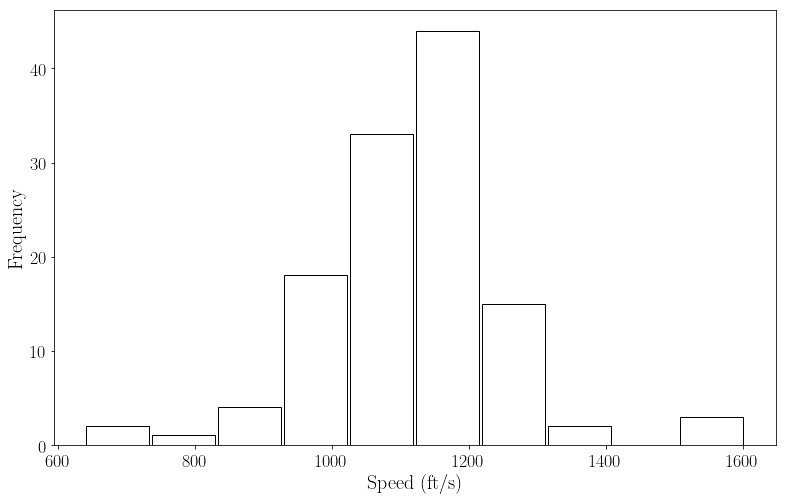

In [17]:
# read some HS video data analysis with speed data
# path to files
root = Path('../hs_video_analysis')
path_to_data_a = root / "20140701_PropaneTank_Phase3_Shot2" / "shot2_fragment_a_velocity.csv"
path_to_data_b = root / "20140701_PropaneTank_Phase3_Shot2" / "shot2_fragment_b_velocity.csv"
path_to_data_c = root / "20140701_PropaneTank_Phase3_Shot2" / "shot2_fragment_c_velocity.csv"
path_to_data_d = root / "20140701_PropaneTank_Phase3_Shot2" / "shot2_fragment_d_velocity.csv"

skip = 1 # skip header lines in data files.
# read function
dfa = read_data(path_to_data_a, skip)
dfb = read_data(path_to_data_b, skip)
dfc = read_data(path_to_data_c, skip)
dfd = read_data(path_to_data_d, skip)

# combine all the speed data into one dataframe
frames = [dfa, dfb, dfc, dfd]
# all speed data in one file
result = pd.concat(frames)
ax = result.sort_values("v").v.plot(kind="hist", histtype='bar', rwidth=0.95, fill=False) #plot a histogram of the speed data.
ax.set_xlabel("Speed (ft/s)");

A useful Python function when you need summary statistics is the describe() function.  As you can see below it provides a quick overview of velocity data.

In [18]:
result.describe()

,v
count,122.000000
mean,1112.882862
std,141.651055
min,639.754710
25%,1033.742678
50%,1131.873717
75%,1182.878358
max,1602.978995


The average velocity measured, $n=122$, $95\% CI$ $(1112\pm423)ft/s$.

There are times when it is not possible to conduct an arena test [[2]](http://www.dtic.mil/dtic/tr/fulltext/u2/629767.pdf) to experimentally determine fragment speeds.  In those cases the fragment speed can be determined from a wonderful series of formulas developed by Gurney [[3]](http://www.dtic.mil/dtic/tr/fulltext/u2/a800105.pdf).  Gurney's equation(s) convert the energy in the expanding detonation gases into the kinetic energy of the case fragments.  Gurney's equations assume a linear speed profile and a uniform but time-varying pressure and density in the detonation gases.  The Gurney Equation is given by:

$$V_0=\frac{\sqrt{2E}}{\left(M/C)+n/(n+2)\right)}$$

where $\sqrt{2E}$ is the experimentally determined gurney-energy, which is specific for an explosive, $M/C$ is the case-metal to charge ratio, and $n$ is a geometry-symmetry-factor for plane $(n=1)$, cylinderical $(n=2)$, spherical $(n=3)$ configurations.  The plot below shows the variation of the metal velocity normalized with the gurney energy, $\sqrt{2E}$, as a function of $\left(M/C\right)$ [[4]](http://dtic.mil/dtic/tr/fulltext/u2/783941.pdf).  This plot shows that at small $M/C$, small case weight compared to charge weight, the geometry of the bomb effects the fragment velocity.

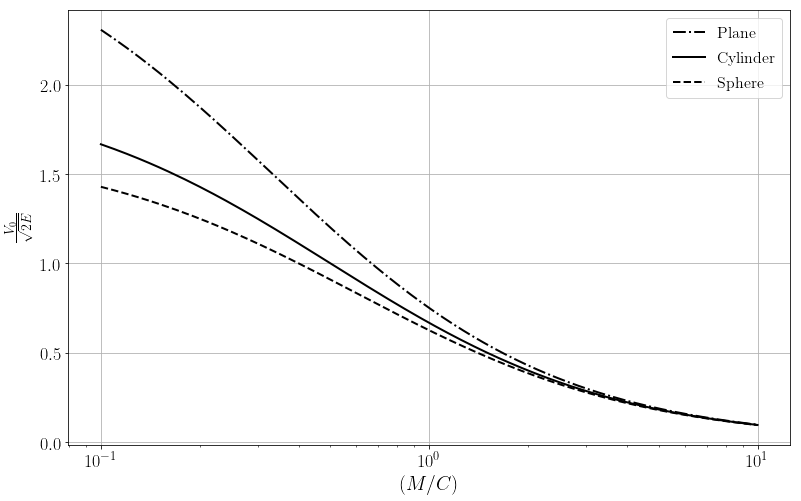

In [29]:
MC = np.arange(0.1,10.,0.01)
VVG_plane = 1/(MC+1/3)
VVG_cylinder = 1/(MC+1/2)
VVG_sphere = 1/(MC+3/5)
fig, ax1 = plt.subplots()
ax1.semilogx(MC, VVG_plane, 'k-.', label="Plane")
ax1.semilogx(MC, VVG_cylinder, 'k-', label="Cylinder")
ax1.semilogx(MC, VVG_sphere, 'k--', label="Sphere")
ax1.set_xlabel(r'$(M/C)$')
ax1.grid(True)
ax1.legend()
ax1.set_ylabel(r'$\frac{V_0}{\sqrt{2E}}$');

The table below from Jacobs shows typical values for the Gurney Energy where the value of $A$ is an arbitrary dimensionless constant replacing $(n/n+1)$ [[4]](http://dtic.mil/dtic/tr/fulltext/u2/783941.pdf).

| High Explosive (HE)               | Best Estimate (ft/sec) A = 0.5 | Best Estimate (ft/sec) A = 0.3 | HE Density (g/cc) |
|-----------------------------------|--------------------------------|--------------------------------|-------------------|
| HMX                               | 9080                           | 8760                           | 1.89              |
| PETN                              | 8990                           | 8670                           | 1.76              |
| RDX                               | 8940                           | 8620                           | 1.79              |
| TNT (cast)                        | 7260                           | 7010                           | 1.60              |
| TNT (pressed)                     | 7260                           | 7010                           | -                 |
| COMP B (64/36)                    | 8280                           | 7990                           | 1.71              |
| COMP B (60/40)                    | 8210                           | 7920                           | 1.70              |
| CYCLONTOL (77/23)                 | 9550                           | 9210                           | 1.75              |
| CYCLONTOL (75/25)                 | 8500                           | 8200                           | 1.72              |
| OCTOL (78/22)                     | 8680                           | 8370                           | 1.82              |
| PENTOLITE (50/50) (cast)          | 8100                           | 7820                           | 1.69              |
| PENTOLITE (50/50) (pressed)       | 8100                           | 7820                           | -                 |
| Nitromethane                      | 7380                           | 7120                           | 1.14              |
| H-6 (RDX/TNT/AL/Wax):(47/31/22/5) | 8380                           | 8080                           | 1.71              |

## Mass Distribution

Fragment mass distribuitions are typically presented as a cumulative distribution function (CDF).  

In [20]:
# Read Data
x = pd.read_csv('PROPANE TCV FRAG.csv')

data = x.wt_g

# sort the data:
data_sorted = np.sort(data)

# calculate the proportional values of samples
p = (1 - 1. * np.arange(len(x)) / (len(x) - 1))*100


# fragment data
x = data_sorted
y = p


def mott(x, MT, m0):
    """Mott Distribution"""
    return (MT/m0)*exp(-(2*x/m0)**0.5)


gmodel = Model(mott)
#result = gmodel.fit(y, x=x, MT=sum(x), m0=sum(x)/len(x))
result = gmodel.fit(y, x=x, MT=1000, m0=10)

print(result.fit_report())
#print(result.eval_uncertainty())

[[Model]]
    Model(mott)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 104
    # variables        = 2
    chi-square         = 737.358898
    reduced chi-square = 7.22900881
    Akaike info crit   = 207.703120
    Bayesian info crit = 212.991902
[[Variables]]
    MT:  6908.69001 +/- 159.538790 (2.31%) (init = 1000)
    m0:  62.9744260 +/- 1.80888571 (2.87%) (init = 10)
[[Correlations]] (unreported correlations are < 0.100)
    C(MT, m0) =  0.980



In [21]:
fragment_mass = 62.9744260
fragment_mass_error = 1.80888571
print("Average Fragment Mass = (%.1f +/-% .1f)g" % (fragment_mass, fragment_mass_error))

Average Fragment Mass = (63.0 +/- 1.8)g


The average fragment mass collected from the TCV has a mass of $63\:\pm\:1.8\:g$.

In [22]:
dely = result.eval_uncertainty(sigma=3)

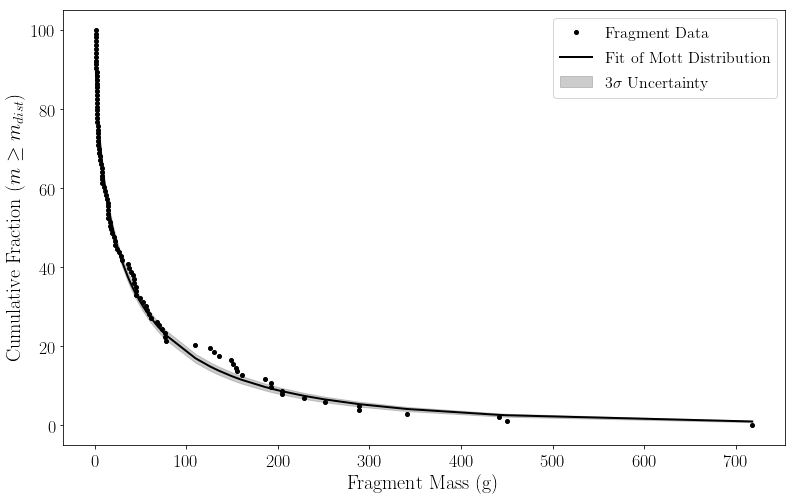

In [23]:
fig, ax1 = plt.subplots()
ax1.plot(x, y, 'k.', label = "Fragment Data")
ax1.plot(x, result.best_fit, 'k-', label = "Fit of Mott Distribution")
ax1.fill_between(x, result.best_fit-dely, result.best_fit+dely, color = "gray", alpha=0.4, label="3$\sigma$ Uncertainty")
ax1.legend()
ax1.set_xlabel('Fragment Mass (g)')
ax1.set_ylabel('Cumulative Fraction $(m\geq m_{dist})$');

In [24]:
from scipy.optimize import fsolve
import math
'''
This code solves two sets of nonlinear equations for the
hazardous fragmentation distance (HFD).  The mass of the
hazardous fragment m = x[0] and the range R = x[1] are
solved for using the optimize.fsolve function.  This is
not designed to solve for a munition with multiple
sections.
'''
def equation1(x):
    # solving for m = x[0] and R = x[1]
    # for the non-freefall fragment energy
    # equation
    C_D = 0.8
    rho = 0.076 # lb/ft
    v_0 = 1063 # ft/sec
    g   = 32.2 # ft/sec^2
    A_T = 6.24 # ft^2
    N_T = 104
    m_0 = fragment_mass*0.00220462 # lb
    k = 162.9 # lb/ft^3
    P = 0.01 # probability
    
    L_1 = (2*k**(2/3))/(C_D*rho)
    ecr1 = 0.5*x[0]*(v_0**2)*math.exp(-(2*x[1])/((L_1)*x[0]**(1/3))) - 58
    q = (N_T/(4*x[1]**2))*math.exp(-(math.sqrt(2*x[0]/m_0)))
    p = 1 - math.exp(-q*A_T) - P # multiple q's for each munition section
    
    return ecr1, p

def equation2(x):
    # solving for m = x[0] and R = x[1]
    # for the freefall fragment energy
    # equation
    C_D = 0.8
    rho = 0.076 # lb/ft
    v_0 = 1063 # ft/sec
    g   = 32.2 # ft/sec^2
    A_T = 6.24 # ft^2
    N_T = 104
    m_0 = fragment_mass*0.00220462 # lb
    k = 162.9 # lb/ft^3
    P = 0.01 # probability
    
    L_1 = (2*k**(2/3))/(C_D*rho)
    ecr2 = 0.5*g*((2*k**(2/3))/(C_D*rho))*x[0]**(4/3) - 58
    q = (N_T/(4*x[1]**2))*math.exp(-(math.sqrt(2*x[0]/m_0)))
    p = 1 - math.exp(-q*A_T) - P
    
    return ecr2, p

x1 = fsolve(equation1, [0.01, 50])
x2 = fsolve(equation2, [0.01, 50])

if x1[0] <= x2[0]:
    m = x1[0]
    R = x1[1]
    C_D = 0.8
    rho = 0.076 # lb/ft
    v_0 = 1063 # ft/sec
    g   = 32.2 # ft/sec^2
    A_T = 6.24 # ft^2
    N_T = 104
    m_0 = fragment_mass*0.00220462 # lb
    k = 162.9 # lb/ft^3
    L_1 = (2*k**(2/3))/(C_D*rho)
    E_cr = 0.5*m*(v_0**2)*math.exp(-(2*R)/((L_1)*m**(1/3)))
    eqn = 1
else:
    m = x2[0]
    R = x2[1]
    C_D = 0.8
    rho = 0.076 # lb/ft
    v_0 = 1063 # ft/sec
    g   = 32.2 # ft/sec^2
    A_T = 6.24 # ft^2
    N_T = 104
    m_0 = fragment_mass*0.00220462 # lb
    k = 162.9 # lb/ft^3
    L_1 = (2*k**(2/3))/(C_D*rho)
    E_cr = 0.5*g*((2*k**(2/3))/(C_D*rho))*m**(4/3)
    eqn = 2

print("1% Probability of Being Struck by HF")
print("HFD = %d ft" % R)
print("mass = %f lb" % m)
print("Energy = %f ft-lb" % E_cr)
print("Equation %d" % eqn)

1% Probability of Being Struck by HF
HFD = 119 ft
mass = 0.001091 lb
Energy = 58.000000 ft-lb
Equation 1


The hazardous fragmentation distance is summaried in the Table below:

| Probability of HFD | HFD Range (ft) | Mass (lb) |
|--------------------|----------------|-----------|
| 1%                 | 119            | 0.001091  |
| 10%                | 37             | 0.000319  |
| 25%                | 23             | 0.000223  |
| 50%                | 14             | 0.000177  |

# References
1.  T. A. Zaker, “Fragment and Debris Hazards (TP-12),” Washington, D.C., 1975.
2.  Picatinny Arsenal, “Fragmentation Testing Procedures,” Dover, NJ, 1950.
3.  R. W. Gurney, “The Initial Velocities of Fragments from Bombs, Shells, and Grenades,” Aberdeen Proving Ground, MD, 1947.
4.  S. J. Jacobs, “The Gurney Formula: Variations on a Theme by Lagrage,” Silver Spring, MD, 1974.
5.  D. Brown, “Tracker 5.0” Open Source Physics, 2018.